Method to find chess squares in a screenshot
---

---
## Start TF session

In [1]:
import tensorflow as tf
import numpy as np
np.set_printoptions(suppress=True)

sess = tf.InteractiveSession()

## Load image

Let's first load a simple chessboard image taken off of reddit, we'll start simple, with the board filling up the entire space. Let's get the imports out of the way

In [2]:
# Imports for visualization
import PIL.Image
from io import StringIO
import scipy.ndimage as nd
import scipy.signal
import cv2


In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

Loaded test.png (3360 x 2100)
Image too big (3360 x 2100)
Reducing by factor of 4.2
New size: (3360 x 2100)


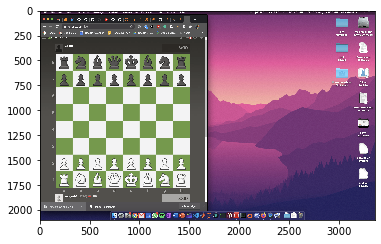

In [4]:
img_file = 'test.png'

img = cv2.imread(img_file)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(f"Loaded {img_file} ({img.shape[1]} x {img.shape[0]})" )

# Resize if image larger than 2k pixels on a side
if img.shape[1] > 2000 or img.shape[0] > 2000:
    print(f"Image too big ({img.shape[1]} x {img.shape[0]})")
    new_size = 800.0 # px
    if img.shape[1] > img.shape[0]:
        # resize by width to new limit
        ratio = new_size / img.shape[1]
        
    else:
        # resize by height
        ratio = new_size / img.shape[0]
    print(f"Reducing by factor of {(1./ratio)}" )
#     img = cv2.resize(img,(0,0),fx=ratio,fy=ratio)
    print (f"New size: ({img.shape[1]} x {img.shape[0]})")

# See original image
plt.imshow(np.asarray(img))

We need to find the chessboard squares within the image (assuming images will vary, boards will vary in color, etc. between different posts in reddit). A assumption we can make that simplifies things greatly is to assume the chessboards will be aligned with the image (orthorectified), so we only need to search for horizontal and vertical lines.

One way is to use horizontal and vertical gradients, and then a simplified hough transform on those gradient images to find the lines.

In [5]:
def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def gradientx(x):
  """Compute the x gradient of an array"""
  gradient_x = make_kernel([[-1.,0., 1.],
                            [-1.,0., 1.],
                            [-1.,0., 1.]])
  return simple_conv(x, gradient_x)

def gradienty(x):
  """Compute the x gradient of an array"""
  gradient_y = make_kernel([[-1., -1, -1],[0.,0,0], [1., 1, 1]])
  return simple_conv(x, gradient_y)

def corners(x):
  """Find chess square corners in an array"""
  chess_corner = make_kernel([[-1., 0, 1],[0., 0., 0.], [1.,0, -1]])
  return simple_conv(x, chess_corner)

# Following are meant for binary images
def dilate(x, size=3):
  """Dilate"""
  kernel = make_kernel(np.ones([size,size], dtype=np.float32))
  return tf.clip_by_value(simple_conv(x, kernel),
                          np.float32(1),
                          np.float32(2))-np.float32(1)

def erode(x, size=3):
  """Erode"""
  kernel = make_kernel(np.ones([size,size]))
  return tf.clip_by_value(simple_conv(x, kernel),
                          np.float32(size*size-1),
                          np.float32(size*size))-np.float32(size*size-1)

def opening(x, size=3):
    return dilate(erode(x,size),size)

def closing(x, size=3):
    return erode(dilate(x,size),size)

def skeleton(x, size=3):
    """Skeletonize"""
    return tf.clip_by_value(erode(x) - opening(erode(x)),
                            0.,
                            1.)

In [6]:
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
a = np.asarray(gray, dtype=np.float32)

Now that we've got our kernels ready for convolution, let's create our tf variables.

In [7]:
A = tf.Variable(a)


Dx = gradientx(A)
Dy = gradienty(A)

# Dxy = np.abs(gradientx(A) * gradienty(A))
# Dc = np.abs(corners(A))



In [8]:
# Initialize state to initial conditions
tf.initialize_all_variables().run()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Let's look at the gradients, we apply opening to them also to clean up noise

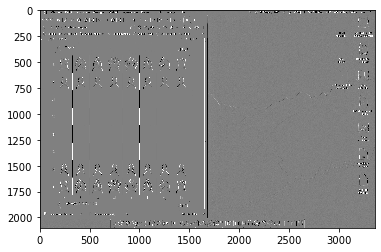

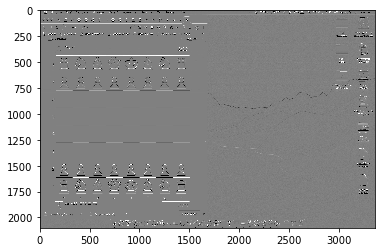

In [9]:
plt.imshow(Dx.eval(), vmin=-255, vmax=255, interpolation='nearest', cmap=plt.cm.gray, aspect='auto')
plt.figure()
plt.imshow(Dy.eval(), vmin=-255, vmax=255, interpolation='nearest', cmap=plt.cm.gray, aspect='auto')

Looks pretty good, now how to find lines? Well with a [Hough transform](https://en.wikipedia.org/wiki/Hough_transform) we resample into a parameter space of lines based on two variables $r$ and $\theta$ for example. In our case we already know we're doing vertical and horizontal lines so instead of a 2D space we just need two 1D spaces. In fact, we can simply do this by summing along the axes for each gradient.

Originally I'd taken the absolute of gradients and found all lines, but a cool trick to take advantage of chessboard patterns is that the internal chessboard lines always alternate. So we take the amplitude of the gradient on that axis those lines will stand out.

In [10]:
Dx_pos = tf.clip_by_value(Dx, 0., 255., name="dx_positive")
Dx_neg = tf.clip_by_value(Dx, -255., 0., name='dx_negative')
Dy_pos = tf.clip_by_value(Dy, 0., 255., name="dy_positive")
Dy_neg = tf.clip_by_value(Dy, -255., 0., name='dy_negative')

In [11]:
hough_Dx = tf.reduce_sum(Dx_pos, 0) * tf.reduce_sum(-Dx_neg, 0) / (a.shape[0]*a.shape[0])
hough_Dy = tf.reduce_sum(Dy_pos, 1) * tf.reduce_sum(-Dy_neg, 1) / (a.shape[1]*a.shape[1])
# Normalized to 0-255*255=65025 range

Let's plot the responses of the summed gradients

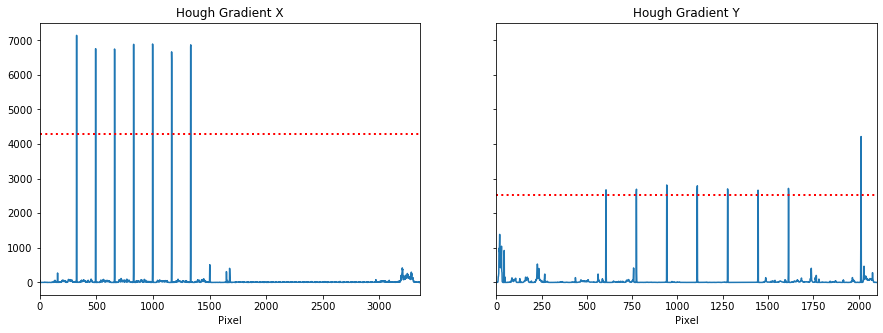

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(15,5))

# Arbitrarily choose half of max value as threshold, since they're such strong responses
hough_Dx_thresh = tf.reduce_max(hough_Dx) * 3 / 5
hough_Dy_thresh = tf.reduce_max(hough_Dy) * 3 /5

ax1.plot(hough_Dx.eval());
ax1.axhline(hough_Dx_thresh.eval(), lw=2,linestyle=':',color='r')
ax1.set_title('Hough Gradient X')
ax1.set_xlabel('Pixel')
ax1.set_xlim(0,a.shape[1])

ax2.plot(hough_Dy.eval())
ax2.axhline(hough_Dy_thresh.eval(), lw=2,linestyle=':',color='r')
ax2.set_title('Hough Gradient Y')
ax2.set_xlim(0,a.shape[0])
ax2.set_xlabel('Pixel');

Awesome, they show up clear as day. Since we've normalized the hough gradients to pixel values of 0-255, let's arbitrarily threshold half-way between.

In [13]:
def checkMatch(lineset):
    """Checks whether there exists 7 lines of consistent increasing order in set of lines"""
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    for line in linediff:
        # Within 5 px of the other (allowing for minor image errors)
        if np.abs(line - x) < 5:
            cnt += 1
        else:
            cnt = 0
            x = line
    return cnt == 5

def pruneLines(lineset):
    """Prunes a set of lines to 7 in consistent increasing order (chessboard)"""
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    start_pos = 0
    for i, line in enumerate(linediff):
        # Within 5 px of the other (allowing for minor image errors)
        if np.abs(line - x) < 5:
            cnt += 1
            if cnt == 5:
                end_pos = i+2
                return lineset[start_pos:end_pos]
        else:
            cnt = 0
            x = line
            print(i, x)
            start_pos = i
    return lineset

def skeletonize_1d(arr):
    """return skeletonized 1d array (thin to single value, favor to the right)"""
    _arr = arr.copy() # create a copy of array to modify without destroying original
    # Go forwards
    for i in range(_arr.size-1):
        # Will right-shift if they are the same
        if arr[i] <= _arr[i+1]:
            _arr[i] = 0
    
    # Go reverse
    for i in np.arange(_arr.size-1, 0,-1):
        if _arr[i-1] > _arr[i]:
            _arr[i] = 0
    return _arr

def getChessLines(hdx, hdy, hdx_thresh, hdy_thresh):
    """Returns pixel indices for the 7 internal chess lines in x and y axes"""
    # Blur
    gausswin = scipy.signal.gaussian(21,4)
    gausswin /= np.sum(gausswin)

    # Blur where there is a strong horizontal or vertical line (binarize)
    blur_x = np.convolve(hdx > hdx_thresh, gausswin, mode='same')
    blur_y = np.convolve(hdy > hdy_thresh, gausswin, mode='same')


    skel_x = skeletonize_1d(blur_x)
    skel_y = skeletonize_1d(blur_y)

    # Find points on skeletonized arrays (where returns 1-length tuple)
    lines_x = np.where(skel_x)[0] # vertical lines
    lines_y = np.where(skel_y)[0] # horizontal lines
    
    # Prune inconsistent lines
    lines_x = pruneLines(lines_x)
    lines_y = pruneLines(lines_y)
    
    is_match = len(lines_x) == 7 and len(lines_y) == 7 and checkMatch(lines_x) and checkMatch(lines_y)
    
    return lines_x, lines_y, is_match

# Get chess lines
lines_x, lines_y, is_match = getChessLines(hough_Dx.eval().flatten(), \
                                           hough_Dy.eval().flatten(), \
                                           hough_Dx_thresh.eval(), \
                                           hough_Dy_thresh.eval())

lines_x, lines_y, is_match = getChessLines(hough_Dx.eval().flatten(), \
                                           hough_Dy.eval().flatten(), \
                                           hough_Dx_thresh.eval()*.9, \
                                           hough_Dy_thresh.eval()*.9)

print("X",lines_x, np.diff(lines_x))
print("Y",lines_y, np.diff(lines_y))
if is_match:
    print("Chessboard found")
else:
    print("Couldn't find Chessboard")

0 168
0 168
0 168
0 168
X [ 326  494  662  830  998 1166 1334] [168 168 168 168 168 168]
Y [ 606  774  942 1110 1278 1446 1614] [168 168 168 168 168 168]
Chessboard found


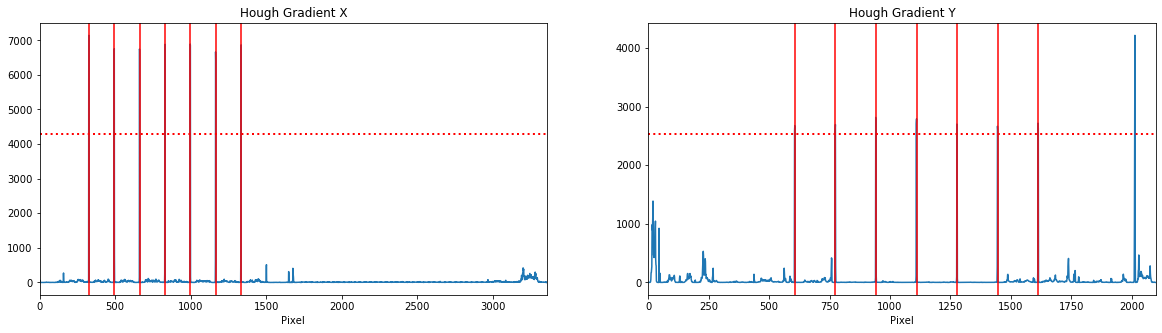

In [14]:
# Plot blurred 1d hough arrays and skeletonized versions
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

ax1.plot(hough_Dx.eval());
ax1.axhline(hough_Dx_thresh.eval(), lw=2,linestyle=':',color='r')
ax1.set_title('Hough Gradient X')
ax1.set_xlabel('Pixel')
ax1.set_xlim(0,a.shape[1])

ax2.plot(hough_Dy.eval())
ax2.axhline(hough_Dy_thresh.eval(), lw=2,linestyle=':',color='r')
ax2.set_title('Hough Gradient Y')
ax2.set_xlim(0,a.shape[0])
ax2.set_xlabel('Pixel');

# Plot lines for where peaks where found
if len(lines_x < 20):
    for hx in lines_x:
        ax1.axvline(hx,color='r')
if len(lines_y < 20):
    for hy in lines_y:
        ax2.axvline(hy,color='r')

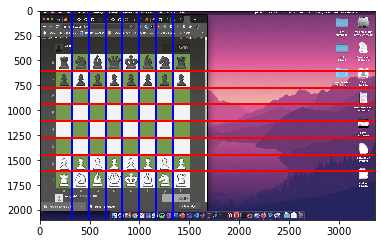

In [15]:
plt.imshow(img)
for hx in lines_x:
    plt.axvline(hx, color='b', lw=2)

for hy in lines_y:
    plt.axhline(hy, color='r', lw=2)

Cool, we've got a set of lines now. We need to figure out which lines are associated with the chessboard, then split up the image into individual squares for feeding into the tensorflow CNN.

In [16]:
print("X   (vertical)",lines_x, np.diff(lines_x))
print("Y (horizontal)",lines_y, np.diff(lines_y))

def getChessTiles(a, lines_x, lines_y):
    """Split up input grayscale array into 64 tiles stacked in a 3D matrix using the chess linesets"""
    # Find average square size, round to a whole pixel for determining edge pieces sizes
    stepx = np.int32(np.round(np.mean(np.diff(lines_x))))
    stepy = np.int32(np.round(np.mean(np.diff(lines_y))))
    
    # Pad edges as needed to fill out chessboard (for images that are partially over-cropped)
#     print stepx, stepy
#     print "x",lines_x[0] - stepx, "->", lines_x[-1] + stepx, a.shape[1]
#     print "y", lines_y[0] - stepy, "->", lines_y[-1] + stepy, a.shape[0]
    padr_x = 0
    padl_x = 0
    padr_y = 0
    padl_y = 0
    
    if lines_x[0] - stepx < 0:
        padl_x = np.abs(lines_x[0] - stepx)
    if lines_x[-1] + stepx > a.shape[1]-1:
        padr_x = np.abs(lines_x[-1] + stepx - a.shape[1])
    if lines_y[0] - stepy < 0:
        padl_y = np.abs(lines_y[0] - stepy)
    if lines_y[-1] + stepx > a.shape[0]-1:
        padr_y = np.abs(lines_y[-1] + stepy - a.shape[0])
    
    # New padded array
#     print "Padded image to", ((padl_y,padr_y),(padl_x,padr_x))
    a2 = np.pad(a, ((padl_y,padr_y),(padl_x,padr_x)), mode='edge')
    
    setsx = np.hstack([lines_x[0]-stepx, lines_x, lines_x[-1]+stepx]) + padl_x
    setsy = np.hstack([lines_y[0]-stepy, lines_y, lines_y[-1]+stepy]) + padl_y
    
    a2 = a2[setsy[0]:setsy[-1], setsx[0]:setsx[-1]]
    setsx -= setsx[0]
    setsy -= setsy[0]
#     display_array(a2, rng=[0,255])    
#     print "X:",setsx
#     print "Y:",setsy
    
    # Matrix to hold images of individual squares (in grayscale)
#     print "Square size: [%g, %g]" % (stepy, stepx)
    squares = np.zeros([np.round(stepy), np.round(stepx), 64],dtype=np.uint8)
    
    # For each row
    for i in range(0,8):
        # For each column
        for j in range(0,8):
            # Vertical lines
            x1 = setsx[i]
            x2 = setsx[i+1]
            padr_x = 0
            padl_x = 0
            padr_y = 0
            padl_y = 0

            if (x2-x1) > stepx:
                if i == 7:
                    x1 = x2 - stepx
                else:
                    x2 = x1 + stepx
            elif (x2-x1) < stepx:
                if i == 7:
                    # right side, pad right
                    padr_x = stepx-(x2-x1)
                else:
                    # left side, pad left
                    padl_x = stepx-(x2-x1)
            # Horizontal lines
            y1 = setsy[j]
            y2 = setsy[j+1]

            if (y2-y1) > stepy:
                if j == 7:
                    y1 = y2 - stepy
                else:
                    y2 = y1 + stepy
            elif (y2-y1) < stepy:
                if j == 7:
                    # right side, pad right
                    padr_y = stepy-(y2-y1)
                else:
                    # left side, pad left
                    padl_y = stepy-(y2-y1)
            # slicing a, rows sliced with horizontal lines, cols by vertical lines so reversed
            # Also, change order so its A1,B1...H8 for a white-aligned board
            # Apply padding as defined previously to fit minor pixel offsets
            squares[:,:,(7-j)*8+i] = np.pad(a2[y1:y2, x1:x2],((padl_y,padr_y),(padl_x,padr_x)), mode='edge')
    return squares


if is_match:
    # Possibly check np.std(np.diff(lines_x)) for variance etc. as well/instead
    print("7 horizontal and vertical lines found, slicing up squares")
    squares = getChessTiles(a, lines_x, lines_y)
    print(f"Tiles generated: ({squares.shape[0]}x{squares.shape[1]})*squares.shape[2]" )
else:
    print("Number of lines not equal to 7")


X   (vertical) [ 326  494  662  830  998 1166 1334] [168 168 168 168 168 168]
Y (horizontal) [ 606  774  942 1110 1278 1446 1614] [168 168 168 168 168 168]
7 horizontal and vertical lines found, slicing up squares
Tiles generated: (168x168)*squares.shape[2]


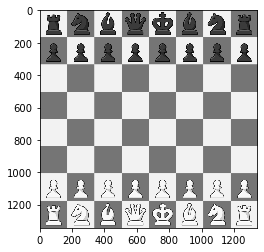

In [17]:
stepx = np.int32(np.round(np.mean(np.diff(lines_x))))
stepy = np.int32(np.round(np.mean(np.diff(lines_y))))
b = a[lines_y[0]-stepy:lines_y[-1]+stepy,lines_x[0]-stepx:lines_x[-1]+stepx]
plt.imshow(b,cmap="gray")

Order is row-wise from top left of image going right and down, so a8,b8....a7,b7,c7...h1
Showing 5 random squares...
#0: A1.0
#1: B1.125
#2: C1.25
#3: D1.375
#4: E1.5
#5: F1.625
#6: G1.75
#7: H1.875
#8: A2.0
#9: B2.125
#10: C2.25
#11: D2.375
#12: E2.5
#13: F2.625
#14: G2.75
#15: H2.875
#16: A3.0
#17: B3.125
#18: C3.25
#19: D3.375
#20: E3.5
#21: F3.625
#22: G3.75
#23: H3.875
#24: A4.0
#25: B4.125
#26: C4.25
#27: D4.375
#28: E4.5
#29: F4.625
#30: G4.75
#31: H4.875
#32: A5.0
#33: B5.125
#34: C5.25
#35: D5.375
#36: E5.5
#37: F5.625
#38: G5.75
#39: H5.875


/Users/sebastiankoch/anaconda3/envs/py37tf15/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


#40: A6.0
#41: B6.125
#42: C6.25
#43: D6.375
#44: E6.5
#45: F6.625
#46: G6.75
#47: H6.875
#48: A7.0
#49: B7.125
#50: C7.25
#51: D7.375
#52: E7.5
#53: F7.625
#54: G7.75
#55: H7.875
#56: A8.0
#57: B8.125
#58: C8.25
#59: D8.375
#60: E8.5
#61: F8.625
#62: G8.75
#63: H8.875


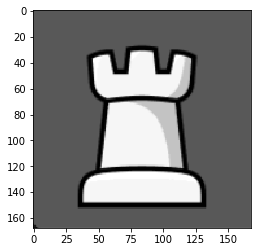

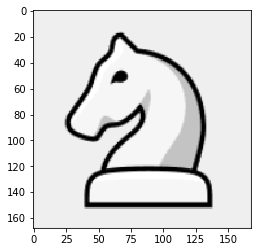

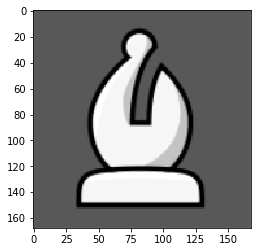

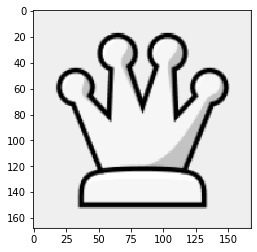

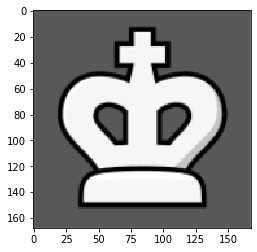

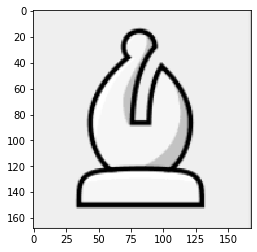

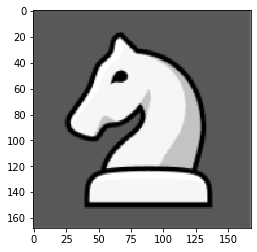

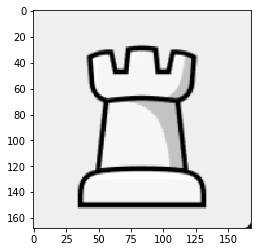

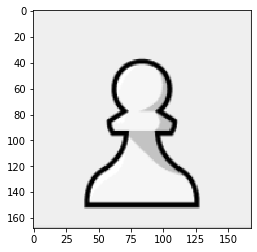

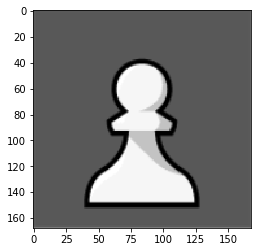

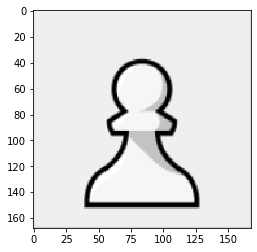

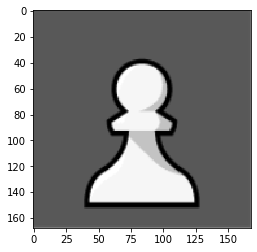

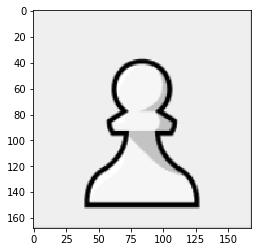

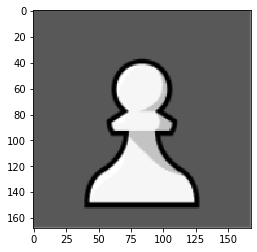

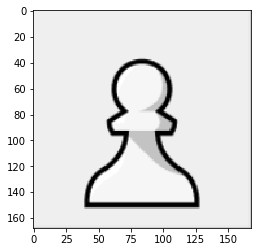

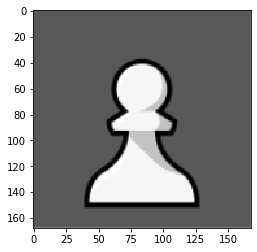

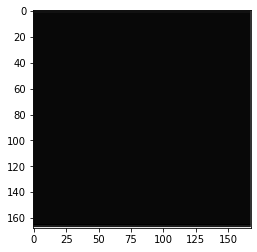

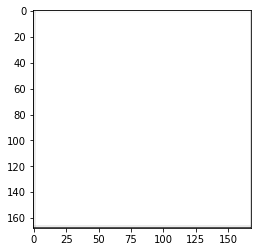

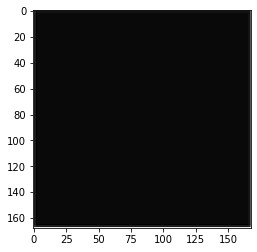

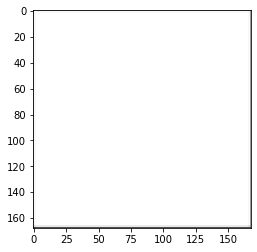

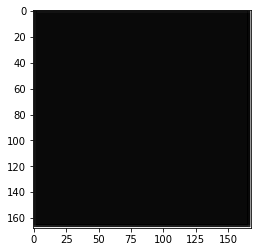

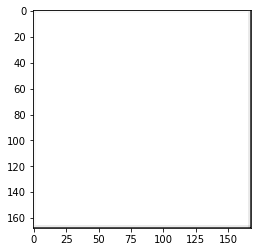

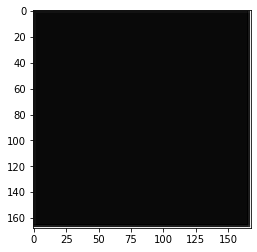

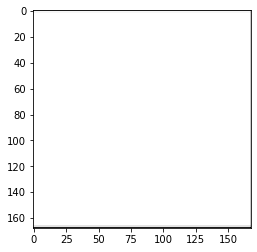

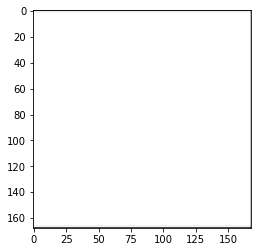

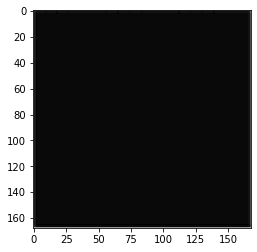

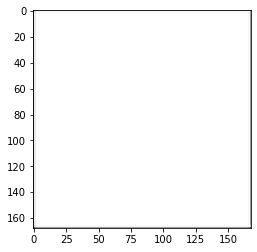

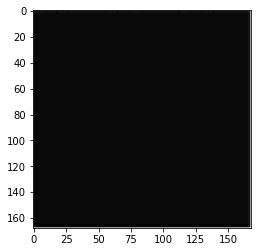

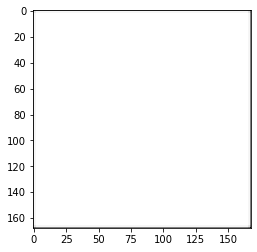

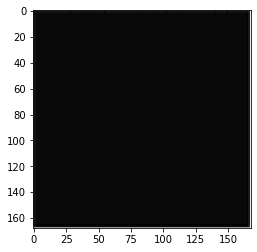

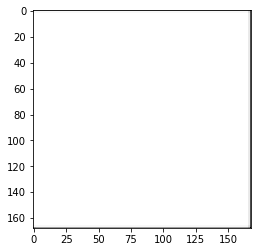

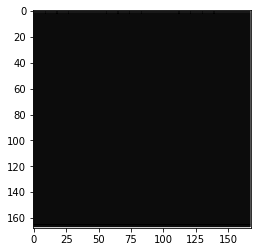

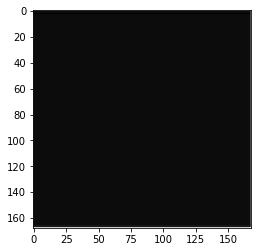

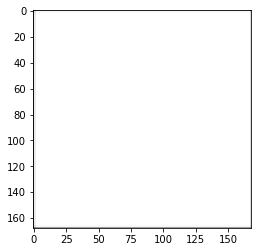

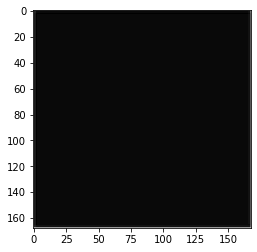

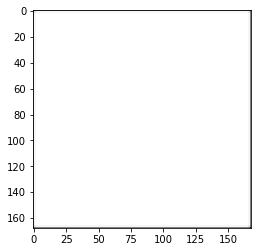

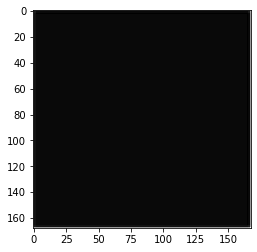

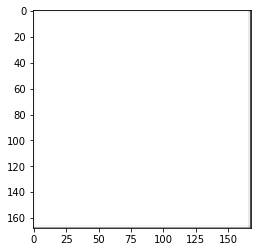

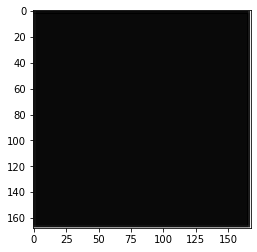

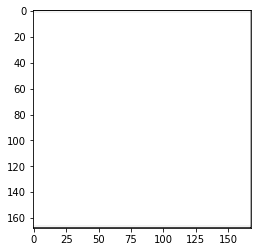

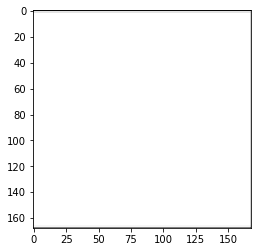

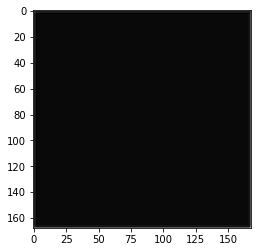

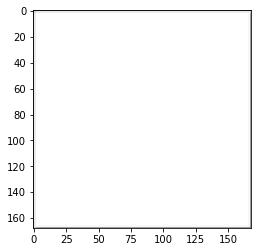

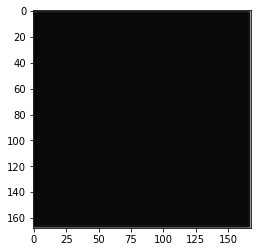

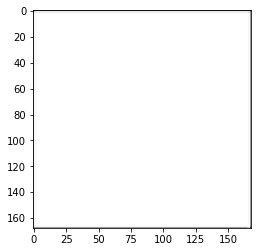

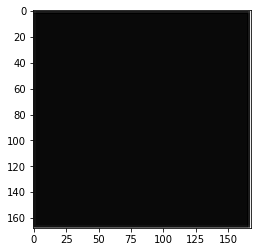

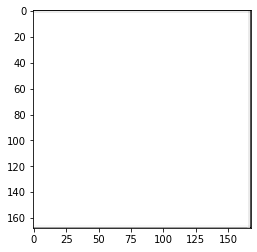

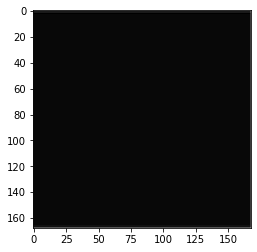

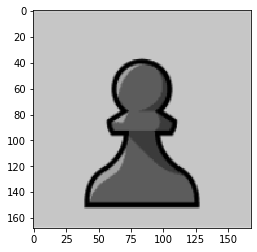

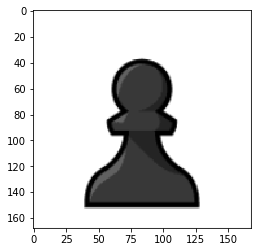

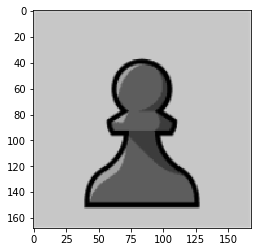

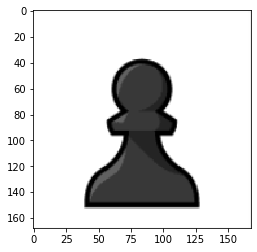

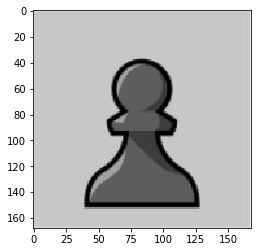

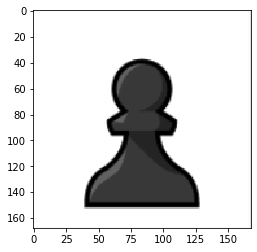

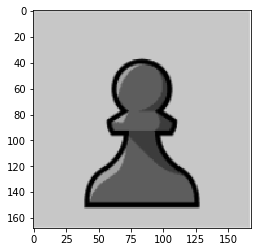

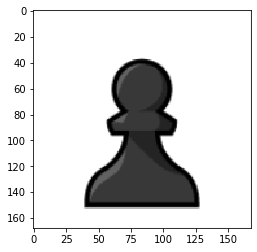

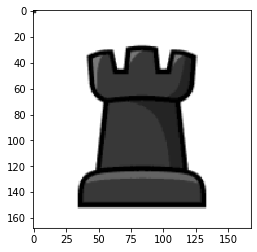

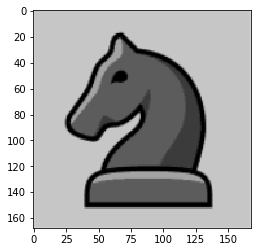

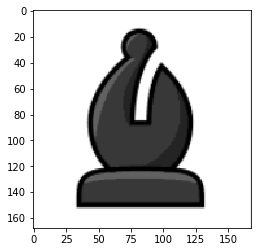

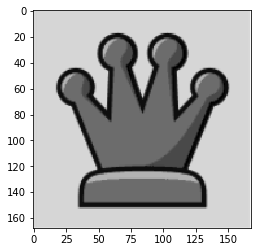

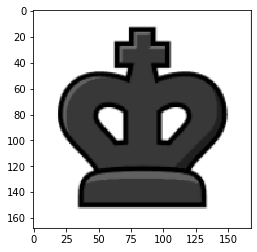

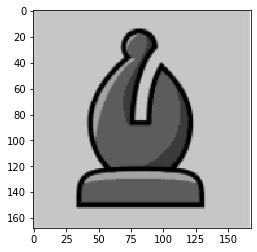

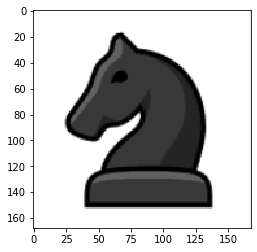

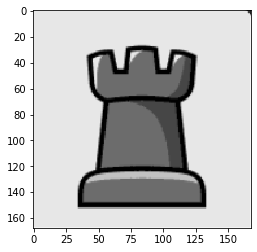

In [18]:
squares = getChessTiles(a, lines_x, lines_y)
letters = 'ABCDEFGH'

if is_match:
    print("Order is row-wise from top left of image going right and down, so a8,b8....a7,b7,c7...h1")
    print("Showing 5 random squares...")
    for i in range(64):
        print(f"#{i}: {letters[i%8]}{(i/8+1)}")
        plt.figure()
        plt.imshow(squares[:,:,i],cmap="gray")
else:
    print("Didn't have lines to slice image up.")